# BTAlert-AI

In [1]:
import os
import time
from datetime import datetime as dt


import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt


os.environ['TZ'] = 'America/Sao_Paulo'
time.tzset()

In [2]:
df_all_samples = pd.read_csv('data/samples.csv', delimiter=';', index_col='timestamp')
df_all_samples.index = [dt.fromtimestamp(x) for x in df_all_samples.index]
df_last_samples = df_all_samples.tail(185)


def heatmap():
    _, ax = plt.subplots(figsize=(16, 9))
    sn.heatmap(df_last_samples.corr(), annot=True, fmt='0.1f', linewidths=.6, ax=ax)


def cpu_memory_system_health_graph():
    _, ax = plt.subplots(figsize=(20, 10))
    df_all_samples.drop(['request_per_sec', 'lock_count', 'req_failed'], axis=1).plot(ax=ax)
    ax.grid()
    ax.legend()


def cpu_memory_system_health_requests_graph():
    plot_data = (
        (
            ('Requests per second', df_last_samples.request_per_sec),
            ('System Health (%)', df_last_samples.system_health)
        ),
        (
            ('CPU consumption (%)', df_last_samples.cpu_percent),
            ('RAM consumption (%)', df_last_samples.memory_percent)
        )
    )

    _, ax = plt.subplots(len(plot_data), len(plot_data[0]), figsize=(22, 11))
    for i, tup in enumerate(plot_data):
        for j, value in enumerate(tup):
            ax[i][j].set_title(value[0])
            ax[i][j].plot(value[1])
            ax[i][j].grid()


## Análise dos dados coletados da aplicação

In [3]:
df_all_samples.head()

,req_failed,request_per_sec,cpu_percent,memory_percent,lock_count,system_health
2022-05-11 07:50:07,0.0,0.00,0.000286,0.681229,1,1.0
2022-05-11 07:50:22,0.0,0.80,0.022767,0.740280,1,1.0
2022-05-11 07:50:37,0.0,12.07,0.065587,0.783585,1,1.0
2022-05-11 07:50:52,0.0,15.27,0.116834,0.881149,1,1.0
2022-05-11 07:51:07,0.0,20.93,0.172781,0.863525,2,1.0


## Dicionário de dados

In [4]:
pd.read_csv('data/samples_data_dict.csv', delimiter=';', index_col='column', dtype=str)

,type,range,example,description
column,,,,
timestamp,int64,"[0,+Inf]",1652266207,timestamp when metrics were collected
req_failed,float64,"[0,1]",0.0559,percentage of requests that failed
request_per_sec,float64,"[0,+Inf]",20.93,requests per second sent to the server
cpu_percent,float64,"[0,1]",0.842445,cpu percentage spent
memory_percent,float64,"[0,1]",0.863525,memory percentage spent
lock_count,int64,"[0,+Inf]",2,number of locks in the database
system_health,float64,"[0,1]",0.9286,server's ability to respond to requests correctly


## Matriz de correlação das métricas

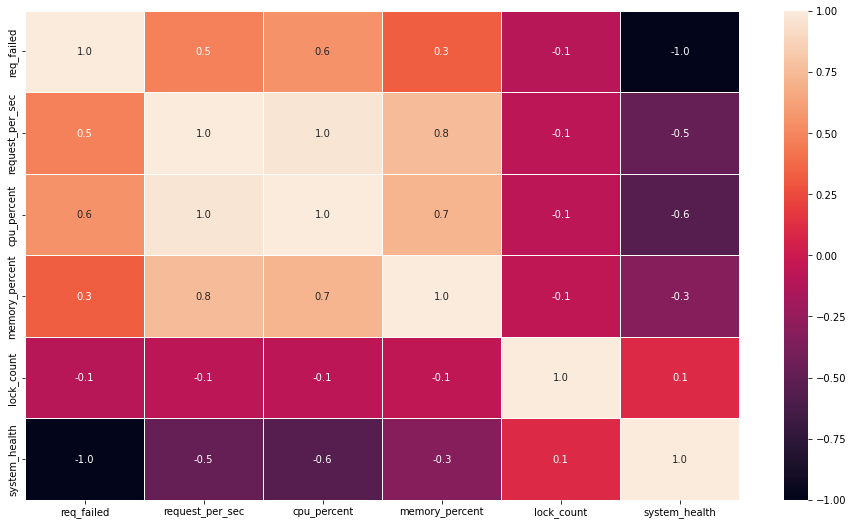

In [5]:
heatmap()

A matriz de correlação diz qual a influência que uma métrica tem em cima de outra. Correlações positivas nos diz que quando uma aumenta, a outra tende a aumentar também, e as negativas dizem que quando uma diminui, a outra aumenta. Com isso, verificamos que a `cpu_percent`, `request_per_sec` e `memory_percent` possuem uma forte correlação negativa com o `system_health`, e por isso foram escolhidas, por fim, a `lock_count` tem uma correlação positiva muito fraca e foi desconsiderada para o modelo de IA.

## Análise das métricas de cpu, memória e saúde do sistema

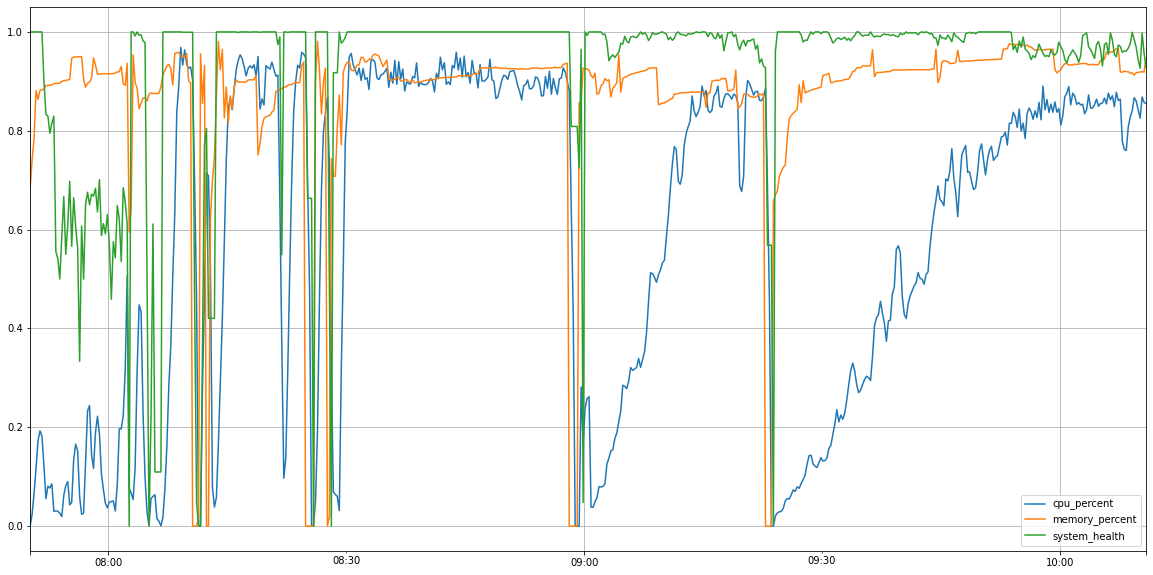

In [6]:
cpu_memory_system_health_graph()

O gráfico acima mostra o uso de CPU, memória RAM e a saúde do sistema em porcentagem ao decorrer do tempo. Notamos que a zona de risco de indisponibilidade é em torno de 80% de uso dos recursos. Caso o sistema fique muito tempo nesta faixa, a saúde do sistema começa a se degradar e o sistema tende a ficar instável e eventualmente indisponível.

## Análise das métricas de requisições por segundo, cpu, memória e saúde do sistema

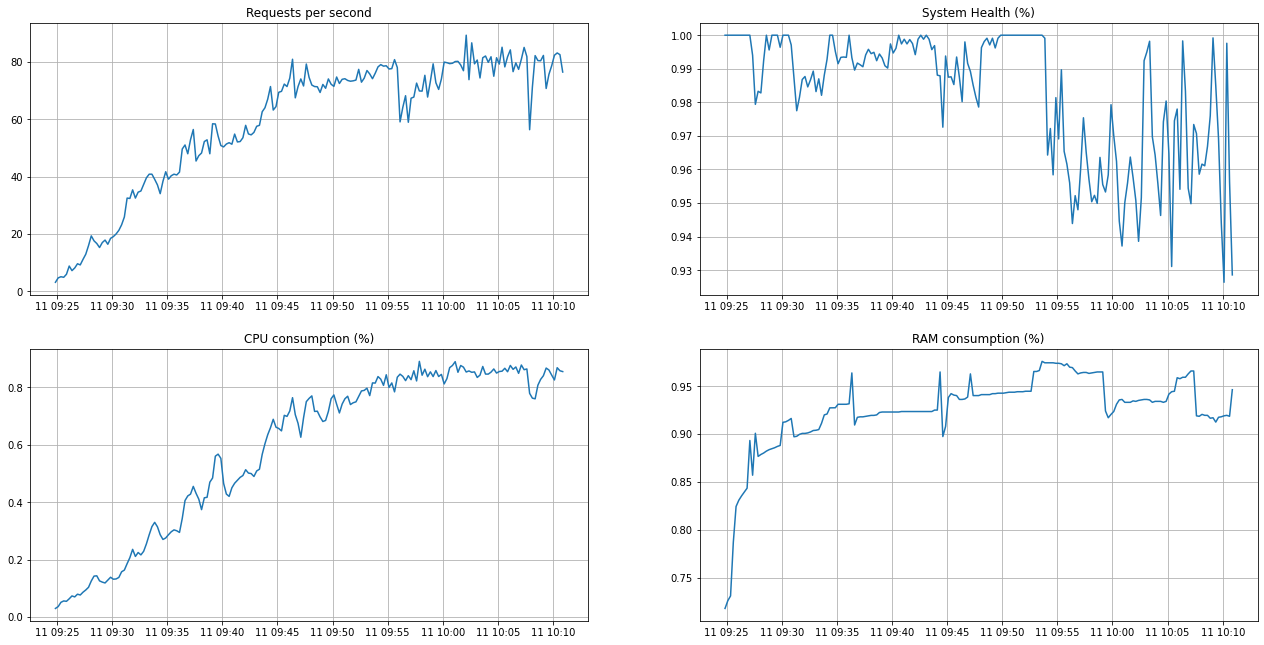

In [7]:
cpu_memory_system_health_requests_graph()

## Conceito de System Health da nossa aplicação
System Health é o principal indicador de disponíbilidade da nossa aplicação. Esta métrica é uma porcentagem que diz sobre a capacidade da API de processar e responder às requisições recebidas.  

Para previsão do System Health utilizamos as seguintes métricas: `cpu_percent`, `request_per_sec` e `memory_percent`.  
Que foram justificadas a pertir da [matriz de correlação](#Matriz-de-correlação-das-métricas) já apresentada.

## Previsão do System Health com LSTM
A previsão da saúde do sistema está disponível neste link: https://colab.research.google.com/drive/1TjYjSaaQG8uydJfeuYG2cL9_lA4f2tr-?usp=sharing